In [ ]:
!pip install pytorch-lightning
!pip install tensorboard
!pip install timm

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision import transforms
# PyTorch Lightning

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

In [ ]:
#!pip install pytorch-lightning

In [ ]:
from torchvision import datasets, transforms

In [ ]:
train_dir = '../AnamolyData/train/images' # load from Kaggle
val_dir= '../AnamolyData/val/images'
transform = transforms.Compose([transforms.Resize((512,512)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])
                               ])
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=18, shuffle=True,drop_last=True) 
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=18, shuffle=True,drop_last=True)
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

In [ ]:
for batch in train_loader:
    print(batch[0].shape)
    print(batch[0].min())
    print(batch[0].max())
    break

In [ ]:
import torch
import timm

In [ ]:
model_names = timm.list_models('*vgg*')
model_names

In [ ]:
encoder = timm.create_model('vgg19_bn',features_only=True, pretrained=True)

In [ ]:
o = encoder(torch.randn(2, 3, 128, 128))
for x in o:
    print(x.shape)

In [ ]:
512*4*4

In [ ]:
encoder=timm.create_model('repvgg_b3',features_only=True, pretrained=False)

In [ ]:
o = encoder(torch.randn(2, 3, 512, 512))
for x in o:
    print(x.shape)

In [ ]:
CHECKPOINT_PATH="anamoly_checkpoints"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [ ]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = timm.create_model('vgg19_bn',features_only=True, pretrained=False)


    def forward(self, x):
        return self.encoder(x)[-1]

In [ ]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 c_hid : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        
        inter1=c_hid//2
        inter2=inter1//2
        inter3=inter2//2
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, inter1, kernel_size=3, output_padding=1, padding=1, stride=2), # 32x32 => 64x64
            act_fn(),
            nn.Conv2d(inter1, inter1, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter1, inter1, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter1, inter1, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter1, inter1, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter1, inter1, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter1, inter1, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d( inter1, inter2, kernel_size=3, output_padding=1, padding=1, stride=2), # 64x64 => 128x128
            act_fn(),
            nn.Conv2d(inter2, inter2, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter2, inter2, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter2, inter2, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter2, inter2, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter2, inter2, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(inter2, inter3, kernel_size=3, output_padding=1, padding=1, stride=2), # 128x128 => 256x256
            act_fn(),
            nn.Conv2d(inter3, inter3, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter3, inter3, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter3, inter3, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter3, inter3, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(inter3, inter3, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(inter3, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 256x256 => 512x512
            act_fn(),
            nn.Conv2d(num_input_channels, num_input_channels, kernel_size=3, padding=1),
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
class Autoencoder(pl.LightningModule):

    def __init__(self,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width:int= 512,
                 height:int= 512):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class()
        self.decoder = decoder_class(num_input_channels, latent_dim)
        self.inception= timm.create_model('vgg19_bn',features_only=True, pretrained=True)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss
    
    @torch.no_grad()
    def _get_inception(self,x):
        z=self.inception(x)[-1]
        return z
    
    def _get_inception_loss(self,batch):
        x, _ = batch # We do not need the labels
        z_hat = self.encoder(x)
        z=self._get_inception(x)
        loss = F.mse_loss(z, z_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss1 = self._get_reconstruction_loss(batch)
        loss2 = self._get_inception_loss(batch)
        loss=loss1+loss2
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

In [ ]:
## Model evaluation
weights="../anamoly_checkpoints/anamoly_road_512/lightning_logs/version_7/checkpoints/epoch=20-step=431046.ckpt"
model = Autoencoder.load_from_checkpoint(weights)

In [ ]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [ ]:
def train_Anamoly(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"anamoly_road_{latent_dim}"),
                         accelerator="cuda" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=1000,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"anamoly_road_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(latent_dim=latent_dim)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    #test_result = trainer.test(model, test_loader, verbose=False)
    result = {"val": val_result}
    return model, result

In [ ]:
train_Anamoly(latent_dim=512)

In [1]:
from utils import *

In [2]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    mu= np.mean(X,axis=0)
    var= np.var(X,axis=0) 
    return mu, var

In [ ]:
## Train features for checking 
train_features=[]
for i,item in enumerate(tqdm(train_loader)):
    if (i>200):
        break
    x,y=item[0],item[1]
    model.cuda()
    model.eval()
    x=x.cuda()
    #x=x.unsqueeze(0)
    y=model.encoder(x).detach().cpu()
    train_features.append(y.flatten(start_dim=1).numpy())

In [ ]:
#print(len(train_features))
train_features=np.concatenate(train_features,axis=0)
train_features.shape

In [ ]:
train_features.shape

In [ ]:
with open('train_features.npy', 'wb') as f:
    np.save(f, train_features)

In [ ]:
with open('train_features.npy', 'rb') as f:
    train_features=np.load(f)

In [ ]:
mu, var = estimate_gaussian(train_features)  

In [ ]:
mu.shape,var.shape

In [3]:
mu=np.random.randn(8192,)
var=np.random.randn(8192,)
train_features=np.random.rand(100000,8192)
mu.shape

(8192,)

In [4]:
## Normal distribution should look like this
p_train = multivariate_gaussian(train_features, mu, var)

/home/ec2-user/SageMaker/Image-Anomaly/utils.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
/home/ec2-user/SageMaker/Image-Anomaly/utils.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
/home/ec2-user/SageMaker/Image-Anomaly/utils.py:27: RuntimeWarning: overflow encountered in exp
  np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))


In [ ]:
## Val features and labels for picking the best threshold
val_features=[]
y_val=[]
for i,item in enumerate(tqdm(val_loader)):
    x,y=item[0],item[1]
    model.cuda()
    model.eval()
    x=x.cuda()
    #x=x.unsqueeze(0)
    y=model.encoder(x).detach().cpu()
    val_features.append(y.flatten(start_dim=1).numpy())
    y_val.append(y_val.detch().cpu().numpy())

In [ ]:
val_features=np.concatenate(val_features)
y_val=np.concatenate(y_val)

In [ ]:
## Data Out of distribution looks like this
p_val = multivariate_gaussian(val_features, mu, var)

In [ ]:
epsilon, F1 = select_threshold(y_val, p_val)
print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

In [ ]:
## Inference and testing

In [3]:
import sys

In [4]:
sys.path.append( '../' )

In [5]:
from models.autoencoder_mu_var import *

In [6]:
from torchvision import datasets, transforms

In [20]:
weights="../ckpts/anamoly_road_512/lightning_logs/version_0/checkpoints/epoch=53-step=51948.ckpt"
model = Autoencoder.load_from_checkpoint(weights,is_training=False)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (encoder): FeatureListNet(
      (features_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (features_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (features_2): ReLU(inplace=True)
      (features_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (features_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (features_5): ReLU(inplace=True)
      (features_6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (features_7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (features_8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (features_9): ReLU(inplace=True)
      (features_10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (features_11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

In [21]:
from PIL import Image
import numpy as np
from torchvision.transforms import InterpolationMode

In [22]:
transform = transforms.Compose([transforms.Resize((128,128),interpolation=InterpolationMode.NEAREST),transforms.ToTensor()])

In [23]:
img_path="/home/ec2-user/SageMaker/AnamolyData/val/images/anamoly/gaussian.png"
img=Image.open(img_path)
a = np.asarray(img)
print(a.min(),a.max())
img=transform(Image.open(img_path))

0 254


In [24]:
img.min(),img.max()

(tensor(0.), tensor(0.9961))

In [25]:
pil_image = transforms.ToPILImage()(img)

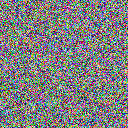

In [26]:
pil_image

In [27]:
img.shape

torch.Size([3, 128, 128])

In [28]:
y=model(img.unsqueeze(0))

In [29]:
y

tensor([[1.1935e-02, 1.2197e-01, 0.0000e+00, 4.1972e-02, 0.0000e+00, 0.0000e+00,
         1.4178e-01, 7.9019e-02, 0.0000e+00, 2.0370e-01, 0.0000e+00, 1.0819e-01,
         9.1222e-03, 2.2651e-02, 4.6361e-03, 0.0000e+00, 1.0152e-02, 0.0000e+00,
         3.6029e-02, 3.1959e-02, 3.6219e-01, 6.4914e-03, 0.0000e+00, 0.0000e+00,
         6.1713e-02, 0.0000e+00, 1.3685e-01, 1.8160e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.9343e-02, 4.5730e-02, 0.0000e+00, 0.0000e+00,
         1.9796e-01, 8.8677e-03, 0.0000e+00, 5.5598e-04, 2.1902e-01, 1.9683e-01,
         2.4641e-02, 0.0000e+00, 9.7545e-02, 1.2733e-01, 0.0000e+00, 4.7614e-01,
         0.0000e+00, 2.6503e-02, 1.3039e-01, 0.0000e+00, 6.4855e-02, 0.0000e+00,
         0.0000e+00, 2.7884e-01, 0.0000e+00, 6.8536e-02, 0.0000e+00, 0.0000e+00,
         2.4350e-01, 0.0000e+00, 0.0000e+00, 3.0843e-01, 0.0000e+00, 0.0000e+00,
         1.4566e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.4025e-02, 6.7833e

In [168]:
target=img.unsqueeze(0).flatten(start_dim=1)
preds=y[0].flatten(start_dim=1)
rec_cosine = F.cosine_similarity(target,preds,dim=1)
euc=relative_euclidean_distance(preds,target,eps=1e-7)
#rec_cosine
rec_cosine

tensor([0.9732], grad_fn=<SumBackward1>)

In [151]:
loss = F.mse_loss(preds, target, reduction="none")
recons_loss  = loss.sum(dim=[1]).mean(dim=[0])
recons_loss

tensor(523.8221, grad_fn=<MeanBackward1>)

In [47]:
y.shape,y[0,512:]

(torch.Size([1, 514]), tensor([0.1263, 0.9923]))

In [48]:
out=transforms.ToPILImage()(y[0].squeeze(0))

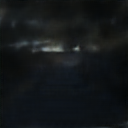

In [49]:
out